# Convolutional autoencoder for image denoising

This example demonstrates how to implement a deep convolutional autoencoder
for image denoising, mapping noisy digits images from the MNIST dataset to
clean digits images. This implementation is based on an original blog post
titled [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
by [François Chollet](https://twitter.com/fchollet).

## Setup

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array,indices):
    """
    Displays ten random images from supplied array
    """
    n = len(indices)
    images = array[indices, :]
    plt.figure(figsize=(20, 4))
    for i, image in enumerate(images):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(image.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()


## Prepare the data

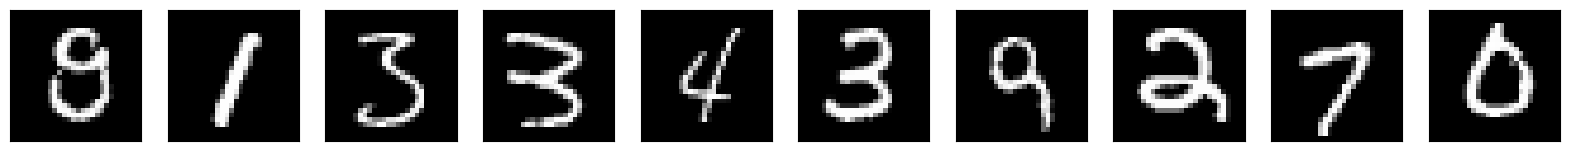

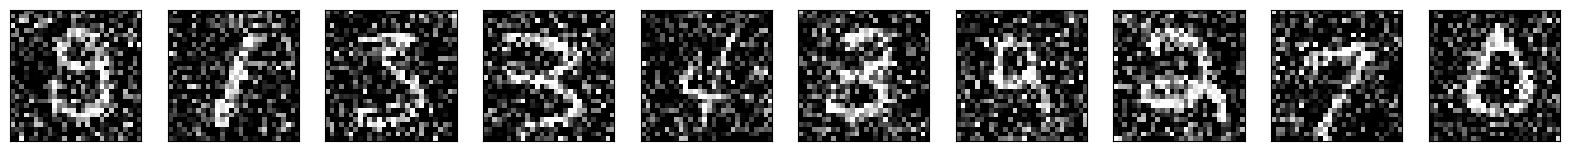

In [2]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Create a set of image indices for displaying 
indices = np.random.randint(len(test_data), size=10)

# Display the train data and a version of it with added noise
#display(train_data, noisy_train_data)
display(train_data, indices)
display(noisy_train_data, indices)

## Build the autoencoder

We are going to use the Functional API to build our convolutional autoencoder.

In [3]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

Now we can train our autoencoder using `train_data` as both our input data
and target. Notice we are setting up the validation data using the same
format.

In [4]:
history = autoencoder.fit( x=train_data, 
                           y=train_data,
                           epochs=10,
                           batch_size=128,
                           shuffle=True,
                           validation_data=(test_data, test_data),
                         )

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 73ms/step - loss: 0.1336 - val_loss: 0.0736
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - loss: 0.0719 - val_loss: 0.0698
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 80ms/step - loss: 0.0696 - val_loss: 0.0684
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 79ms/step - loss: 0.0684 - val_loss: 0.0675
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 77ms/step - loss: 0.0676 - val_loss: 0.0669
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - loss: 0.0670 - val_loss: 0.0663
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 78ms/step - loss: 0.0665 - val_loss: 0.0659
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - loss: 0.0661 - val_loss: 0.0656
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - loss: 0.0658 - val_loss: 0.0652
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - loss: 0.0655 - val_loss: 0.0649


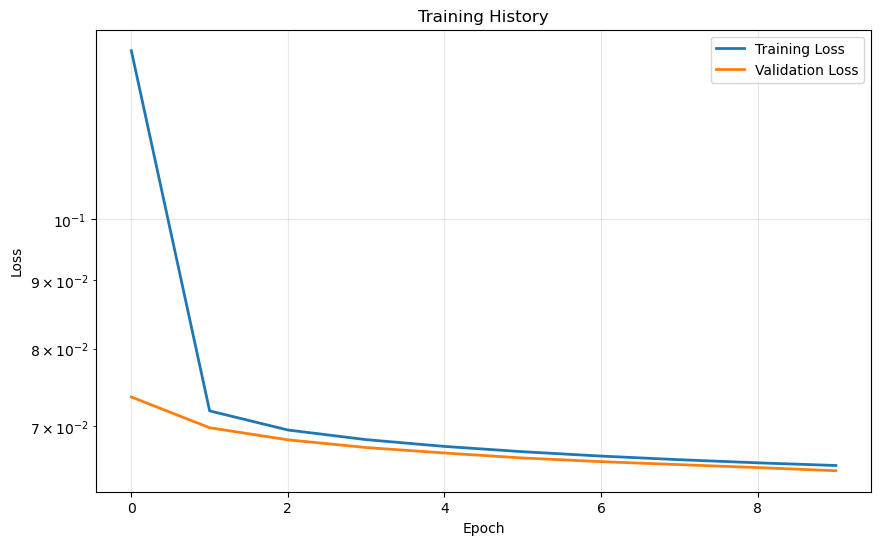

In [9]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.yscale('log')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Let's predict on our test dataset and display the original image together with
the prediction from our autoencoder.

Notice how the predictions are pretty close to the original images, although
not quite the same.

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


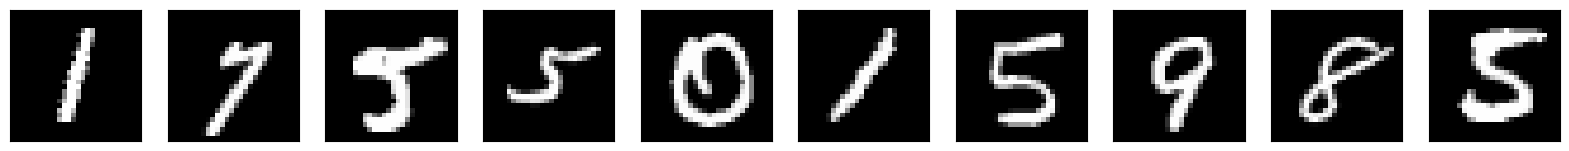

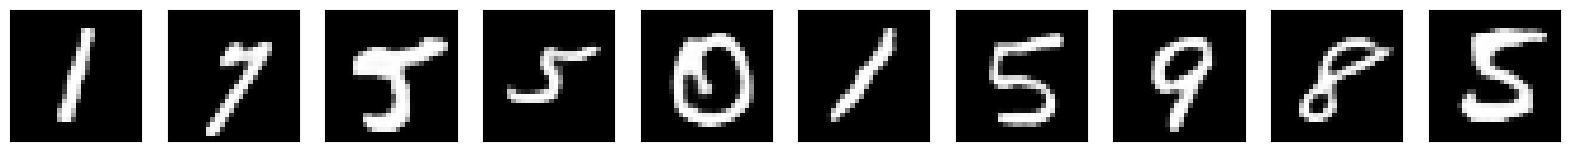

In [6]:
# Infer the autoencoder predictions
predictions = autoencoder.predict(test_data)

# Create a set of image indices for displaying 
indices = np.random.randint(len(test_data), size=10)

# Display input data and predictions
display(test_data,indices)
display(predictions, indices)


Now that we know that our autoencoder works, let's retrain it using the noisy
data as our input and the clean data as our target. We want our autoencoder to
learn how to denoise the images.

In [7]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 79ms/step - loss: 0.1019 - val_loss: 0.0941
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 79ms/step - loss: 0.0938 - val_loss: 0.0921
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - loss: 0.0921 - val_loss: 0.0906
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - loss: 0.0910 - val_loss: 0.0898
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step - loss: 0.0902 - val_loss: 0.0892
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - loss: 0.0896 - val_loss: 0.0883
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - loss: 0.0889 - val_loss: 0.0878
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - loss: 0.0884 - val_loss: 0.0874
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - loss: 0.0880 - val_loss: 0.0872
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - loss: 0.0877 - val_loss: 0.0868


Let's now predict on the noisy data and display the results of our autoencoder.

Notice how the autoencoder does an amazing job at removing the noise from the
input images.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


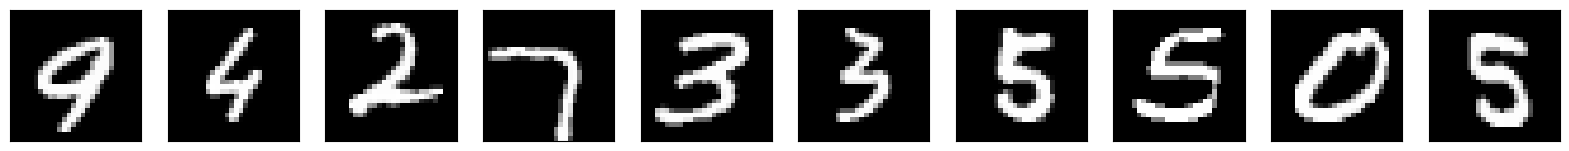

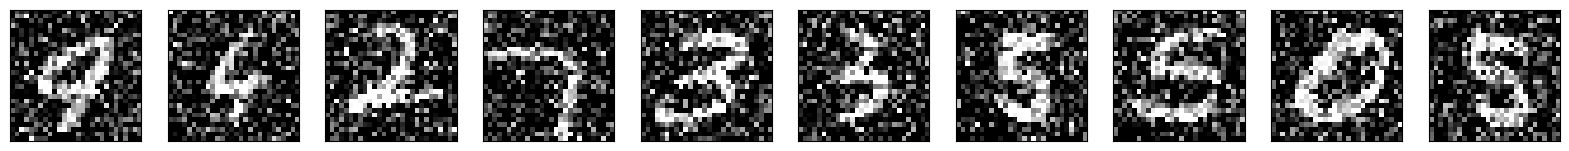

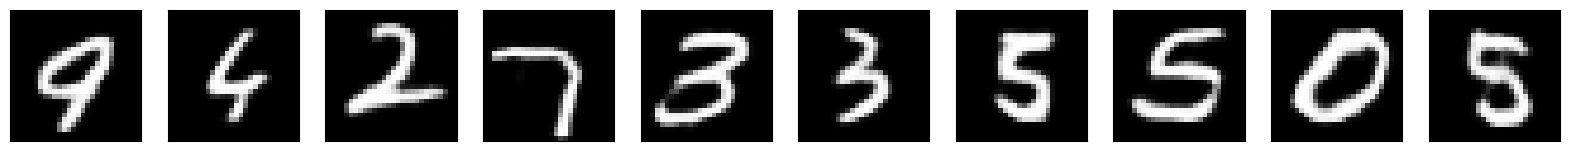

In [8]:
predictions = autoencoder.predict(noisy_test_data)

# Create a set of image indices for displaying 
indices = np.random.randint(len(test_data), size=10)

display(test_data, indices)
display(noisy_test_data, indices)
display(predictions, indices)